In [1]:
import os
from os.path import join, exists, splitext, basename
from imp import reload
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch.nn import Parameter
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader

from pixyz.distributions import Bernoulli, Normal
from pixyz.losses import KullbackLeibler, CrossEntropy
from pixyz.models import Model

from models import *
from utils import *

from mnist_A_data_loader import get_mnist_A_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_loader = get_mnist_A_loader("../data/MNIST_A/train_X/",
                                  "../data/MNIST_A/train_y.npy")
test_loader = get_mnist_A_loader("../data/MNIST_A/test_X/",
                                 "../data/MNIST_A/test_y.npy", mode="test")
valid_loader = get_mnist_A_loader("../data/MNIST_A/valid_X/", 
                                  "../data/MNIST_A/valid_y.npy")

log_dir = "./logs"
classifier = MNIST_A_Classifier().to(device)
classifier.load_state_dict(torch.load(join(log_dir, 'MNIST_A_classifier.pkl')))
classifier.eval()

z_dim = 2
y_dim = 2

loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim, name="p_prior")
E = CVAE_Encoder(z_dim=z_dim, y_dim=y_dim).to(device)
D = CVAE_Decoder(z_dim=z_dim, y_dim=y_dim).to(device)

reconst = CrossEntropy(E, D)
kl = KullbackLeibler(E, prior)
loss_cls = reconst.mean() + kl.mean()
print(loss_cls)

experiment_name =  'CVAE_MNIST_A_z_dim{}'.format(z_dim)

cuda
mean(-(E_p(z|x,y)[log p(x|z,y)])) + mean(KL[p(z|x,y)||p_prior(z)])


# train

625it [00:30, 20.22it/s]


train
↓generate


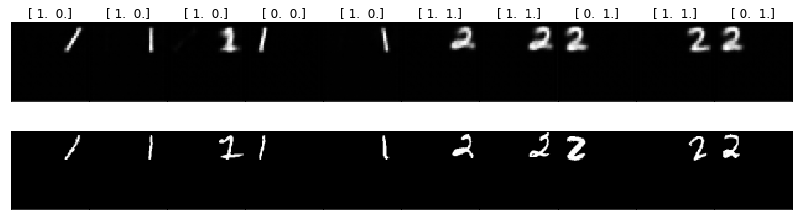

↑true
valid
↓generate


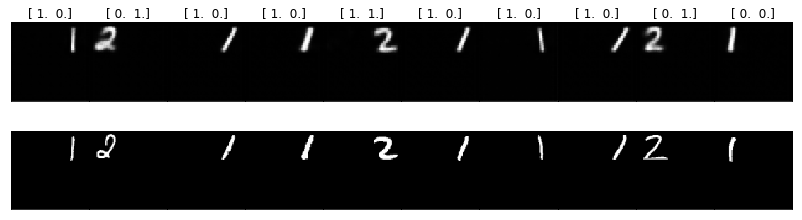

2it [00:00, 19.07it/s]

↑true


625it [00:31, 19.99it/s]


train
↓generate


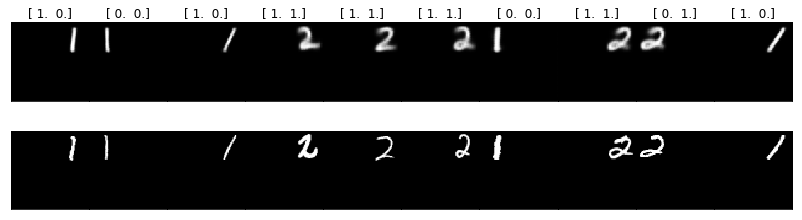

↑true
valid
↓generate


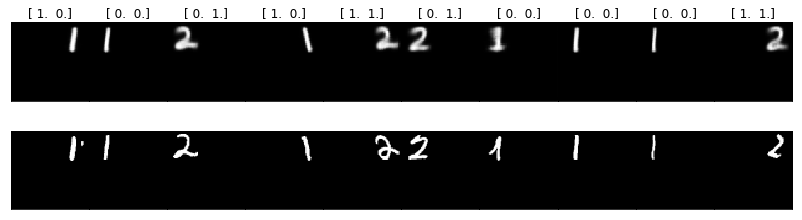

2it [00:00, 19.24it/s]

↑true


625it [00:31, 19.94it/s]


train
↓generate


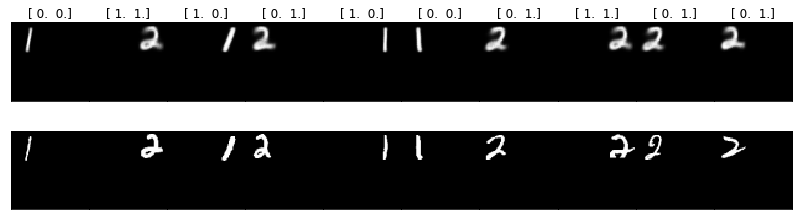

↑true
valid
↓generate


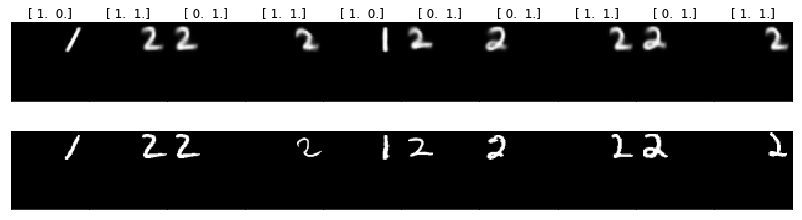

2it [00:00, 17.89it/s]

↑true


625it [00:31, 19.83it/s]


train
↓generate


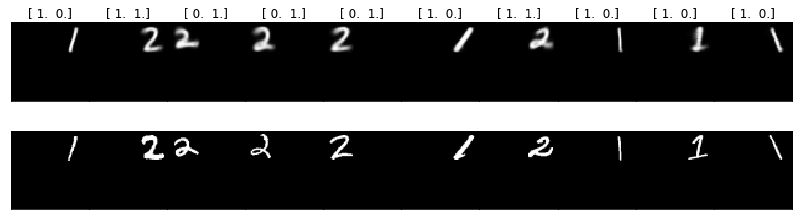

↑true
valid
↓generate


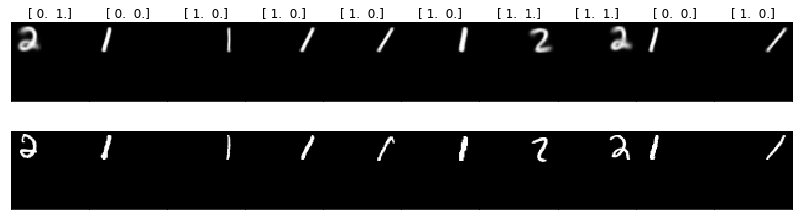

2it [00:00, 18.85it/s]

↑true


625it [00:32, 19.43it/s]


train
↓generate


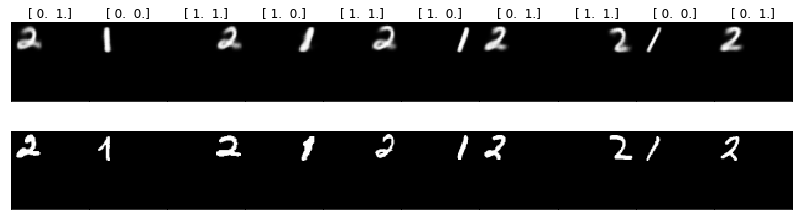

↑true
valid
↓generate


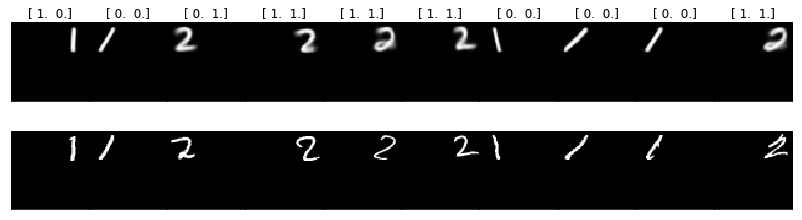

↑true


In [2]:
model = Model(loss_cls, distributions=[E, D], optimizer=optim.Adam, optimizer_params={"lr":5e-4})

for i in range(5):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = label2onehot(y)
        y = y.to(device)
        loss = model.train({"x": x, "y": y})
 
    print("train")
    encoder_plot(train_loader, E, D)
    print("valid")
    encoder_plot(valid_loader, E, D)

torch.save(E.state_dict(), join(log_dir, 'E_{}.pkl'.format(experiment_name)))
torch.save(D.state_dict(), join(log_dir, 'D_{}.pkl'.format(experiment_name)))


# 検証

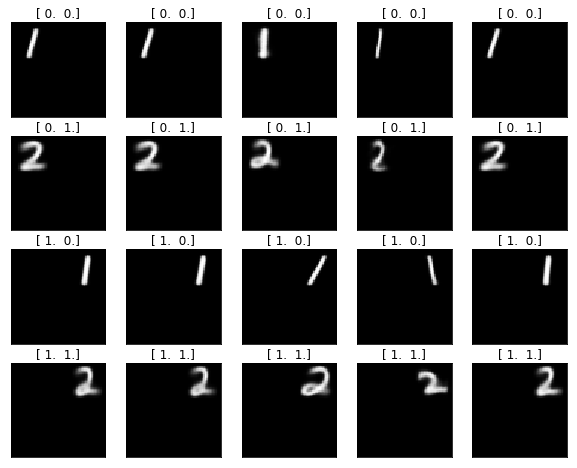

In [3]:
z_dim = 2
y_dim = 2

E = CVAE_Encoder(z_dim=z_dim, y_dim=y_dim).to(device)
D = CVAE_Decoder(z_dim=z_dim, y_dim=y_dim).to(device)

E.load_state_dict(torch.load(join(log_dir, 'E_{}.pkl'.format(experiment_name))))
D.load_state_dict(torch.load(join(log_dir, 'D_{}.pkl'.format(experiment_name))))

D.eval()

sample_size = 5
label_num = 4
labels = []
for i in range(2):
    for j in range(2):
        for k in range(sample_size):
            labels.append([i, j])

labels = torch.FloatTensor(labels).to(device)

torch.random.manual_seed(42)
z = torch.randn(sample_size, z_dim).repeat(label_num, 1).to(device)
samples = D.sample_mean({"z": z, "y": labels.to(device)})
samples_ = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()
plt.figure(figsize=(sample_size*2, label_num*2))
for i in range(sample_size*label_num):
    plt.subplot(label_num, sample_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("{}".format(labels[i].detach().cpu().numpy(), fontsize=15))
    plt.imshow(samples_[i], plt.cm.gray)
plt.show()